# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [10]:
df['group'].value_counts()

control       4264
experiment    3924
Name: group, dtype: int64

In [17]:
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [23]:
dup = df[df.duplicated(subset=['id'])]
dup

,timestamp,id,group,action
8,2016-09-24 20:58:01.948663,349125,experiment,click
12,2016-09-24 21:06:27.553057,601714,experiment,click
15,2016-09-24 21:30:02.739756,487634,experiment,click
17,2016-09-24 23:01:12.108316,468601,experiment,click
21,2016-09-25 00:01:47.933853,555973,experiment,click
...,...,...,...,...
8162,2017-01-17 23:20:35.483601,451198,control,click
8164,2017-01-17 23:47:58.209653,252195,control,click
8167,2017-01-18 00:56:24.554729,344770,experiment,click
8180,2017-01-18 08:54:56.879682,615849,experiment,click


In [31]:
action_counts = df.groupby('action')['id'].count()
print(action_counts)

# Find IDs in both click and view
click_ids = set(df[df['action'] == 'click']['id'])
view_ids = set(df[df['action'] == 'view']['id'])
common_ids = click_ids.intersection(view_ids)
n = len(common_ids)

print("Users who both clicked and viewed;", n)


action
click    1860
view     6328
Name: id, dtype: int64
Users who both clicked and viewed; 1860


In [33]:
#clicked but didn't view

click_only = click_ids - view_ids
c = len(click_only)

print("Users that clicked but didn't view:", c)

Users that clicked but didn't view: 0


In [35]:
group_counts = df.groupby('group')['id'].count()
print(group_counts)

experiment_ids = set(df[df['group'] == 'experiment']['id'])
control_ids = set(df[df['group']== 'control']['id'])
overlap_ids = experiment_ids.intersection(control_ids)

o = len(overlap_ids)

print("Users in both experiment and control groups:", o)

group
control       4264
experiment    3924
Name: id, dtype: int64
Users in both experiment and control groups: 0


There are no anomalies  or overlap of control gropus for the experiment

All users that clicked viewed and users in the control group were not found in the experiment group and vice versa

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

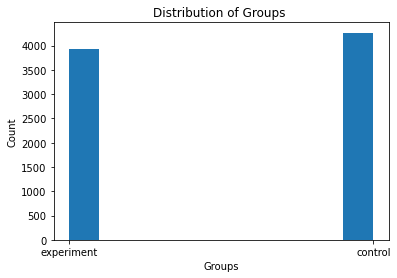

In [44]:
#values, counts = np.unique(df['groups'], return_counts=True)

fig, ax = plt.subplots()
ax.hist(df['group'])
ax.set_xlabel("Groups")
ax.set_ylabel("Count")
ax.set_title("Distribution of Groups ");

In [46]:
control_conver = control_ids.intersection(click_ids)
experiment_conver = experiment_ids.intersection(click_ids)
cc = len(control_conver)
ec = len(experiment_conver)

print('Successful control conversions;', cc)
print('Successful eperiment conersions:', ec)

Successful control conversions; 932
Successful eperiment conersions: 928


In [48]:
from statsmodels.stats.proportion import proportions_ztest

# Define the number of successes (e.g., conversions, clicks) and the sample sizes for control and experiment groups
success_control = 932  # number of successes in control group
obs_control = 4264  # total observations in control group

success_experiment = 928  # number of successes in experiment group
obs_experiment = 3924  # total observations in experiment group

# Perform two-sample proportion test
successes = [success_control, success_experiment]
obs = [obs_control, obs_experiment]

z_stat, p_value = proportions_ztest(successes, obs)

# Check the p-value against a significance level (e.g., alpha = 0.05) to determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("The experimental homepage is statistically more effective than the control group.")
else:
    print("There is no statistically significant difference between the experimental and control groups.")

print("p-value:", p_value)


There is no statistically significant difference between the experimental and control groups.
p-value: 0.05320294852289522


## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [50]:
#Your code here
expected_clicks_experiment = obs_experiment * (success_control / obs_control)

expected_clicks_experiment

857.6848030018762

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [53]:
#Your code here
std_dev_experiment = (obs_experiment * success_control * (1 - success_control / obs_control)) ** 0.5

z_score = (success_experiment - expected_clicks_experiment) / std_dev_experiment

print("std_exp",std_dev_experiment)
z_score

std_exp 1690.5045884593899


0.04159420653344945

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [54]:
#Your code here
import scipy.stats as stats

p_value = 1 - stats.norm.cdf(z_score)
p_value

0.4834110958816451

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**

In [ ]:
#nope

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.